In [1]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import importlib
import logging

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from utilities.baseclass import BaseClass
from utilities.baseevaluation import BaseEvaluation
from utilities.baseplot import BasePlot
from utilities.ivevaluation import IVEvaluation

importlib.reload(sys.modules["utilities.baseclass"])
importlib.reload(sys.modules["utilities.baseevaluation"])
importlib.reload(sys.modules["utilities.baseplot"])
importlib.reload(sys.modules["utilities.ivevaluation"])

import utilities.basefunctions
importlib.reload(sys.modules["utilities.basefunctions"])

from utilities.corporate_design_colors_v4 import cmap
importlib.reload(sys.modules["utilities.corporate_design_colors_v4"])

importlib.reload(logging)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format="%(message)s")
# pip install numpy matplotlib scipy tqdm torch hdf5view h5py PySide6


In [23]:
# Evaluation for unbroken
from utilities.ivevaluation import IVEvaluation
importlib.reload(sys.modules["utilities.ivevaluation"])
%matplotlib qt
eva = IVEvaluation()
eva.file_directory = "/Users/oliver/Documents/measurement data/"
eva.file_folder = "23 10 PR-22e-09/"
eva.file_name = "23_12_08_S22_breaking_4.hdf5"
eva.setAmplifications(1000, None)

V_gap = 189e-6
v_norm = np.linspace(0.01,5.99,599)
V_norm = np.concatenate((-np.flip(v_norm),v_norm))
eva.voltage_axis = V_norm * V_gap

eva.setI(400e-9, current_bins=1000)
eva.showMeasurements()
# eva.showStatus()

eva.eva_temperature = True
eva.downsample_frequency = 43

eva.title = "Breaking Study"
eva.sub_folder = "breaking study"
eva.setMeasurement("positions")
eva.showKeys()
eva.setKeys(index_0=4, index_1=None, norm=1e0, to_pop="")
eva.up_sweep, = eva.getMaps(trigger_indices=[1], y_lim = (.348, .38))
eva.saveData()

(base) ... BaseClass initialized.
(base eva) ... BaseEvaluation initialized.
(iv eva) ... IVEvaluation initialized.
(base eva) Available measurements:
- "positions"
(base) Breaking Study
(base eva) Measurement keys preview: ['pos=+0.00000004', 'pos=+0.00010008', 'pos=+0.49989996', 'pos=+0.50000000']
(iv eva) getBackupTemperature()
100%|██████████| 319/319 [00:22<00:00, 14.45it/s]
(base) saveData()


In [21]:
# plotting brekaing study
%matplotlib qt
from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])

eva = IVPlot()
eva.plot_ivs = False
eva.plot_T = True
eva.smoothing = False

# print(eva.didv_norm)
eva.y_norm = (1e0, '')
eva.dvdi_norm = (1e3, 'k')

eva.y_characters = [r"$x$", "arb. units"]
eva.sub_folder = "breaking study"

eva.title = "Breaking Study"
eva.loadData()
eva.plot_all()

(base) ... BaseClass initialized.
(base eva) ... BaseEvaluation initialized.
(iv eva) ... IVEvaluation initialized.
(base) ... BaseClass initialized.
(base plot) ... BasePlot initialized.
(iv plot) ... IVPlot initialized.
(iv plot) smoothing = False
Breaking Study
(base) loadData()
(base plot) saveFigure()
(base plot) saveFigure()


In [ ]:
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
Vgap = 191e-6      # V
Delta = Vgap*e     # V * A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A

(base) saveData()


# Theoretical Data

In [35]:
path = '../theo_data/CarlosIV'
arr = os.listdir(f'{path}')
arr.remove('iv.in')
arr.remove('iv.for')

v_norm = np.linspace(0.01,5.99,599)
V_norm = np.concatenate((-np.flip(v_norm),v_norm))
T_theo = np.zeros(len(arr)+1, dtype='float64')
I_norm_theo = np.zeros((len(T_theo), len(v_norm)), dtype='float64')

for i in range(len(arr)):
    temp = arr[i][:-4]
    value = int(temp)*10**(-len(temp)+1)
    T_theo[i+1] = value

for i, a in enumerate(arr):
    v_norm_theo = np.genfromtxt(f'{path}/{a}')[:,0]
    i_norm_theo = np.genfromtxt(f'{path}/{a}')[:,1]
    I_norm_theo[i+1,:] = bin_y_over_x(v_norm_theo, i_norm_theo, v_norm)

I_theo = np.concatenate((-np.flip(I_norm_theo, axis=1),I_norm_theo), axis=1)

dIdV_theo = np.gradient(I_theo, V_norm, axis=1)

carlos = {
    'voltage': V_norm,
    'transmission': T_theo,
    'current': I_theo,
    'dIdV': dIdV_theo,
}

theo = dict(
    voltage = carlos['voltage'],
    transmission = carlos['transmission'],
    current = carlos['current'],
    dIdV = carlos['dIdV'],
    )

with open('theo', 'wb') as f:
    pickle.dump(theo, f)


# Get Gap energy from tunnel junction

Text(0.5, 1.0, 'd$I$d$V$ @ $\\tau=0.025$, $\\Delta=191\\,$µeV')

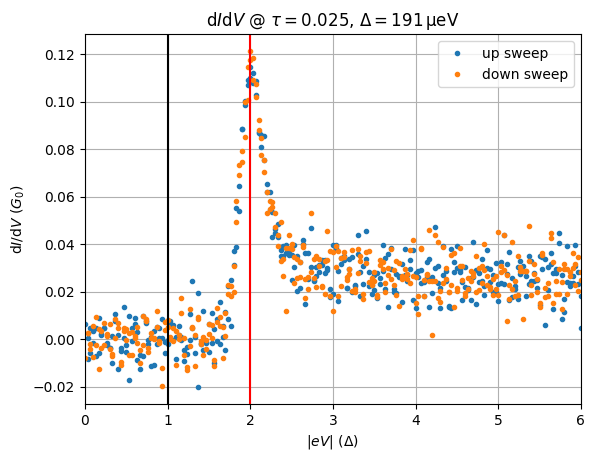

In [36]:
V1_AMP = 1000
V2_AMP = 10000
R_REF = 53000

path = os.getcwd()
file = h5py.File(f'{path}\..\..\\23 11 15 PR22e9 0.025G0\\23_11_15_S22_tunneljuntion_0.025G0_1.hdf5', 'r')

mkey = "single IV_+0.00mT_nanGHz_+nandBm"

offset= file['measurement'][mkey]["offset"]["adwin"]

off_v1 = np.nanmean(offset["V1"])
off_v2 = np.nanmean(offset["V2"])
sweep = file['measurement'][mkey]["sweep"]["adwin"]

trigger = np.array(sweep['trigger'], dtype='int')
v1 = np.array(sweep['V1'], dtype='float64')
v2 = np.array(sweep['V2'], dtype='float64')

v_raw = (v1 - off_v1) / V1_AMP
i_raw = (v2 - off_v2) / V2_AMP / R_REF

v_raw_up = v_raw[trigger==1]
v_raw_down = v_raw[trigger==2]

i_raw_up = i_raw[trigger==1]
i_raw_down = i_raw[trigger==2]

V_raw = np.linspace(-6*191e-6, 6*191e-6, 360+1)

I_raw_up = bin_y_over_x(v_raw_up, i_raw_up, V_raw)
I_raw_down = bin_y_over_x(v_raw_down, i_raw_down, V_raw)

dIdV_raw_up= np.gradient(I_raw_up, V_raw)
dIdV_raw_down= np.gradient(I_raw_down, V_raw)

tunnel_junction ={
    "voltage_raw": V_raw,
    "voltage": V_raw/V_gap,
    "transmission": 0.025,
    "current_up_raw": I_raw_up,
    "current_up": I_raw_up*h/(2*e*Delta),
    "current_down_raw": I_raw_down,
    "current_down": I_raw_down*h/(2*e*Delta),
    "dIdV_up_raw": dIdV_raw_up,
    "dIdV_up": dIdV_raw_up/G_0,
    "dIdV_down_raw": dIdV_raw_down,
    "dIdV_down": dIdV_raw_down/G_0,
}

%matplotlib inline
plt.close(3)
plt.figure(3)

plt.plot(np.abs(tunnel_junction['voltage']), tunnel_junction['dIdV_up'],   '.', label='up sweep')
plt.plot(np.abs(tunnel_junction['voltage']), tunnel_junction['dIdV_down'], '.', label='down sweep')
ylim = plt.ylim()

plt.vlines(1, ymin=ylim[0], ymax=ylim[1], color='k',   )#label=fr'$1\,\Delta = {1*V_gap*1e6:.1f}\,$µeV', zorder=1)
plt.vlines(2, ymin=ylim[0], ymax=ylim[1], color='red', )#label=fr'$2\,\Delta = {2*V_gap*1e6:.1f}\,$µeV', zorder=1)

plt.xlim([0,6])

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel(r'$|eV|\ (\Delta)$')
plt.ylabel(r'd$I/$d$V\ (G_0)$')
plt.title('d$I$d$V$ @ $\\tau=0.025$, $\Delta=191\,$µeV')

# Get Exp Data

In [55]:
path = os.getcwd()
file = h5py.File('D:\\Documents\\measurement data\\23 11 30 PR22e9 breaking\\23_12_08_S22_breaking_4.hdf5', 'r')
liste = list(file['measurement'].keys())
for l in liste:
    print(f'{l}')

positions


In [57]:
# %matplotlib inline
# plt.figure(figsize=(6,1))
# plt.semilogy(file["status"]["femtos"]["amp_A"], label='amp_a')
# plt.semilogy(file["status"]["femtos"]["amp_B"], label='amp_b')
# plt.legend()

V1_AMP = 1e3
R_REF = 51689

In [58]:
mkey='positions'
y, skeys = get_keys(
file=file, 
mkey=mkey, 
to_pop=None,
i1=4, 
i2=-1, 
)

ylim = (.348, .38)
index = (np.argmin(np.abs(y-ylim[0])), np.argmin(np.abs(y-ylim[1])))
y = y[index[0]:index[1]]
skeys = skeys[index[0]:index[1]]
print(index[1]-index[0])

319


In [59]:
def IV_mapping(
    file,
    mkey,
    skeys,
    y,
    V_min=-1e-3,
    V_max=1e-3,
    N_bins=1e3,
    V1_AMP=1e3,
    R_REF=51689,
    trigger_up=1,
    trigger_down=2,
    upsampling=None,
    V_gap = 191e-6,
    ):    
    
    f_keyed = file["measurement"][mkey]
    mcbj = file['status']['bluefors']['temperature']['MCBJ']
    V = np.linspace(V_min, V_max, int(N_bins)+1)

    I_up     = np.full((np.shape(y)[0], np.shape(V)[0]), np.nan, dtype='float64')
    I_down   = np.full((np.shape(y)[0], np.shape(V)[0]), np.nan, dtype='float64')
    t_up     = np.full((np.shape(y)[0], 2),              np.nan, dtype='float64')
    t_down   = np.full((np.shape(y)[0], 2),              np.nan, dtype='float64')
    femto_v1 = np.full((np.shape(y)[0], 1),              np.nan, dtype='float64')
    femto_v2 = np.full((np.shape(y)[0], 1),              np.nan, dtype='float64')

    for i, k in enumerate(tqdm(skeys)):
        offset= f_keyed[k]["offset"]["adwin"]
        sweep = f_keyed[k]["sweep"]["adwin"]
        
        off_v1 = np.nanmean(offset["V1"])
        off_v2 = np.nanmean(offset["V2"])

        trigger = np.array(sweep['trigger'], dtype='int')
        t_temp = np.array(sweep['time'], dtype='float64')

        t_temp_up   = t_temp[trigger==trigger_up]
        t_temp_down = t_temp[trigger==trigger_down]

        t_up[i]   = (t_temp_up[0],   t_temp_up[-1])
        t_down[i] = (t_temp_down[0], t_temp_down[-1])

        keys= list(f_keyed[k].keys())
        keys.remove('set_voltage')
        keys.remove('sweep')
        keys.remove('offset')
        possible_amps = np.full((len(keys)), 1)
        possible_amp_keys = []
        for j, key in enumerate(keys):
            possible_amps[j] = int(key[5:])
            possible_amp_keys.append(key)
        startzeitpunkte = np.full(np.shape(possible_amps), 0)

        for j, possible_amp in enumerate(possible_amps):
            startzeitpunkte[j] = np.min(np.array(f_keyed[k][possible_amp_keys[j]]['sweep']['adwin']['time'], dtype='float64'))
        
        ind = np.argmin(startzeitpunkte)
        V2_AMP = possible_amps[ind]

        femto_v1[i] = V1_AMP
        femto_v2[i] = V2_AMP

        v1 = np.array(sweep['V1'], dtype='float64')
        v2 = np.array(sweep['V2'], dtype='float64')        

        v_raw = (v1 - off_v1) / V1_AMP
        i_raw = (v2 - off_v2) / V2_AMP / R_REF
        
        v_raw_up  =  v_raw[trigger==trigger_up]
        i_raw_up  =  i_raw[trigger==trigger_up]

        v_raw_down  =  v_raw[trigger==trigger_down]
        i_raw_down  =  i_raw[trigger==trigger_down]

        i_up   = bin_y_over_x(v_raw_up,   i_raw_up,   V, upsampling=upsampling)
        i_down = bin_y_over_x(v_raw_down, i_raw_down, V, upsampling=upsampling)

        I_up[i,:] = i_up
        I_down[i,:] = i_down

    dIdV_up   = np.gradient(I_up,   V, axis=1)
    dIdV_down = np.gradient(I_down, V, axis=1)
    
    mcbj = file['status']['bluefors']['temperature']['MCBJ']
    temp_t = np.array(mcbj['time'])
    temp_T = np.array(mcbj['T'])
    
    T_up   = np.full(np.shape(t_up)[0], np.nan)
    N_T_up = np.full(np.shape(t_up)[0], np.nan)
    
    T_down   = np.full(np.shape(t_down)[0], np.nan)
    N_T_down = np.full(np.shape(t_down)[0], np.nan)

    for i, t0 in enumerate(tqdm(t_up)): 
        i0 = np.argmin(np.abs(temp_t-t0[0]))
        i1 = np.argmin(np.abs(temp_t-t0[1]))
        T_up[i] = np.nanmean(temp_T[i0:i1])
        N_T_up[i] = i1-i0
    for i, t0 in enumerate(tqdm(t_down)): 
        i0 = np.argmin(np.abs(temp_t-t0[0]))
        i1 = np.argmin(np.abs(temp_t-t0[1]))
        T_down[i] = np.nanmean(temp_T[i0:i1])
        N_T_down[i] = i1-i0

    DICT = dict(
        V=V/V_gap, 
        pos=y,
        I_up=I_up*h/(2*e*Delta), 
        I_down=I_down*h/(2*e*Delta), 
        dIdV_up=dIdV_up/G_0, 
        dIdV_down=dIdV_down/G_0, 
        t_up=t_up, 
        t_down=t_down,
        femto_v1=femto_v1,
        femto_v2=femto_v2,
        T_up=T_up,
        N_T_up=N_T_up,
        T_down=T_down,
        N_T_down=N_T_down,
        R_ref=R_REF,
        v = V,
        i_up = I_up,
        i_down = I_down,
        )

    return DICT


In [60]:
V_gaps = [191e-6, 190e-6, 189e-6, 188e-6, 187e-6, 186e-6, 185e-6, 184e-6, 183e-6]
for V_gap in V_gaps:
    exp_data = IV_mapping(
        file = file,
        mkey = mkey,
        skeys = skeys,
        y = y,
        V_min=-5.99*V_gap,
        V_max=+5.99*V_gap,
        N_bins=599+599,
        V1_AMP=V1_AMP,
        R_REF=51689,
        V_gap=V_gap,
        )
    exp_data['Vgap'] = V_gap

    with open(f"exp_data_Vgap={int(exp_data['Vgap']*1e6)}e-06", 'wb') as f:
        pickle.dump(exp_data, f)

# 1m 50s

100%|██████████| 319/319 [00:00<00:00, 1624.95it/s]


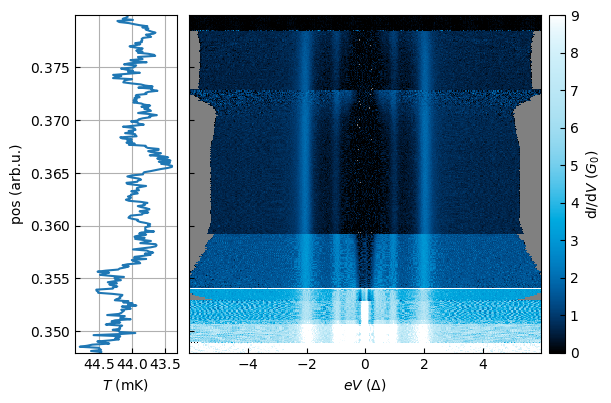

In [61]:
fig, ax_img, ax_plot, ax_clb, ext = IV_T_plotting(    
        img = exp_data['dIdV_down'],
        x = exp_data['V'],
        y = exp_data['pos'],
        x_n = exp_data['T_down'] *1000,
        # x_lim=(-.8, .8),
        # y_lim = (.348, .38),
        clim=(0,9),
        xlabel='$eV$ ($\Delta$)',
        ylabel='pos (arb.u.)',
        xnlabel='$T$ (mK)',
        clabel='d$I/$d$V$ ($G_0$)',
        cmap = cmap(bad='grey'),
        dpi=100,        
        )
fig.savefig('data.png', dpi=600)

In [63]:
# Decrapted

with open('exp_data_Vgap=191e-06', 'rb') as f:
    exp_data = pickle.load(f)

exp_up = dict(
    voltage = np.delete(exp_data['V'], 599),
    position = exp_data['pos'],
    current = np.delete(exp_data['I_up'], 599, axis=1),
    dIdV = np.delete(exp_data['dIdV_up'], 599, axis=1),
    temperature = exp_data['T_up'],
    N_T = exp_data['N_T_up'],
    time = exp_data['t_up'][:,0],
    duration = exp_data['t_up'][:,1]-exp_data['t_up'][:,0],
    R_ref = exp_data['R_ref'],
    femto_V = np.mean(exp_data['femto_v1']),
    femto_I = np.ravel(exp_data['femto_v2']),
)

# Filter out V=0, and uncommonly high Transmission
dely = np.array([9, 60], dtype='int32')
dely = np.concatenate((np.arange(27),np.array([60])), dtype='int32') # decrapt channel number 9 or higher
delx = np.array([599], dtype='int32')

exp_down = dict(
    voltage = np.delete(exp_data['V'], delx),
    position = np.delete(exp_data['pos'], dely),
    current = np.delete(np.delete(exp_data['I_down'], delx, axis=1), dely, axis=0),
    dIdV = np.delete(np.delete(exp_data['dIdV_down'], delx, axis=1), dely, axis=0),
    temperature = np.delete(exp_data['T_down'], dely),
    N_T = np.delete(exp_data['N_T_down'], dely),
    time = np.delete(exp_data['t_down'][:,0], dely),
    duration = np.delete(exp_data['t_down'][:,1]-exp_data['t_down'][:,0], dely),
    R_ref = exp_data['R_ref'],
    femto_V = np.mean(exp_data['femto_v1']),
    femto_I = np.delete(np.ravel(exp_data['femto_v2']), dely),
    Vgap = exp_data['Vgap'],
)

exp_3ch = dict(
    voltage = exp_down['voltage'],
    position = np.delete(exp_down['position'], np.arange(33)),
    time = np.delete(exp_down['time'], np.arange(33)),
    duration = np.delete(exp_down['duration'], np.arange(33)),
    temperature = np.delete(exp_down['temperature'], np.arange(33)),
    N_T = np.delete(exp_down['N_T'], np.arange(33)),
    R_ref = exp_down['R_ref'],
    femto_V = exp_down['femto_V'],
    femto_I = np.delete(exp_down['femto_I'], np.arange(33)),
    current = np.delete(exp_down['current'], np.arange(33), axis=0),
    dIdV = np.delete(exp_down['dIdV'], np.arange(33), axis=0),
)
exp_6ch = dict(
    voltage = exp_down['voltage'],
    position = np.delete(exp_down['position'], np.arange(33, len(exp_down['position']))),
    time = np.delete(exp_down['time'], np.arange(33, len(exp_down['position']))),
    duration = np.delete(exp_down['duration'], np.arange(33, len(exp_down['position']))),
    temperature = np.delete(exp_down['temperature'], np.arange(33, len(exp_down['position']))),
    N_T = np.delete(exp_down['N_T'], np.arange(33, len(exp_down['position']))),
    R_ref = exp_down['R_ref'],
    femto_V = exp_down['femto_V'],
    femto_I = np.delete(exp_down['femto_I'], np.arange(33, len(exp_down['position']))),
    current = np.delete(exp_down['current'], np.arange(33, len(exp_down['position'])), axis=0),
    dIdV = np.delete(exp_down['dIdV'], np.arange(33, len(exp_down['position'])), axis=0),
)

voltage_indices = np.concatenate((np.arange(350), np.arange(len(exp_down['voltage'])-350, len(exp_down['voltage']))))
exp_down['conductance'] = np.nanmean(exp_down['dIdV'][:,voltage_indices], axis=1)
exp_3ch['conductance'] = np.nanmean(exp_3ch['dIdV'][:,voltage_indices], axis=1)
exp_6ch['conductance'] = np.nanmean(exp_6ch['dIdV'][:,voltage_indices], axis=1)

import pickle
with open('exp_3ch_Vgap=191e-06', 'wb') as file:
    pickle.dump(exp_3ch, file)
with open('exp_6ch_Vgap=191e-06', 'wb') as file:
    pickle.dump(exp_6ch, file)


In [62]:
temp_files = [
    "exp_data_Vgap=183e-06",
    "exp_data_Vgap=184e-06",
    "exp_data_Vgap=185e-06",
    "exp_data_Vgap=186e-06",
    "exp_data_Vgap=187e-06",
    "exp_data_Vgap=188e-06",
    "exp_data_Vgap=189e-06",
    "exp_data_Vgap=190e-06",
    "exp_data_Vgap=191e-06",
]

dely = np.array([9, 60], dtype='int32') # decrapt corrupted measurements
dely = np.concatenate((np.arange(27),np.array([60])), dtype='int32') # decrapt channel number 9 or higher
delx = np.array([599], dtype='int32')

voltage_indices = np.concatenate((np.arange(350), np.arange(len(exp_down['voltage'])-350, len(exp_down['voltage']))))

for temp_file in temp_files:
    with open(temp_file, 'rb') as f:
        exp_data = pickle.load(f)

    exp_down = dict(
        voltage = np.delete(exp_data['V'], delx),
        position = np.delete(exp_data['pos'], dely),
        current = np.delete(np.delete(exp_data['I_down'], delx, axis=1), dely, axis=0),
        dIdV = np.delete(np.delete(exp_data['dIdV_down'], delx, axis=1), dely, axis=0),
        temperature = np.delete(exp_data['T_down'], dely),
        N_T = np.delete(exp_data['N_T_down'], dely),
        time = np.delete(exp_data['t_down'][:,0], dely),
        duration = np.delete(exp_data['t_down'][:,1]-exp_data['t_down'][:,0], dely),
        R_ref = exp_data['R_ref'],
        femto_V = np.mean(exp_data['femto_v1']),
        femto_I = np.delete(np.ravel(exp_data['femto_v2']), dely),
        Vgap = exp_data['Vgap'],
    )
    exp_down['conductance'] = np.nanmean(exp_down['dIdV'][:,voltage_indices], axis=1)

    with open(f"exp_6ch_3ch_Vgap={int(exp_data['Vgap']*1e6)}e-06", 'wb') as f:
        pickle.dump(exp_down, f)